In [1]:
import os,shutil,sys
sys.path.append('/data/py/lib/') 
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.applications import xception
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import Model
import time
original_dataset_dir='/data/keras/download/qiche/all'
base_dir='/data/keras/download/qiche'
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')
mod_names=["速腾","朗逸","捷达","迈腾","高尔夫","桑塔纳","帕萨特",
          "思域","本田CR-V","雅阁",
          "雷凌","威驰","凯美瑞","卡罗拉",
          "轩逸","天籁",
          "福克斯","福睿斯","蒙迪欧"]
mod_names=["速腾","迈腾","雷凌","卡罗拉","凯美瑞","天籁","雅阁","朗逸",
          "威驰","福克斯","福睿斯","蒙迪欧","轩逸","帕萨特","途观","飞度","锋范"]
epochs=10
nnn=len(mod_names)
img_height=384
img_width=512
img_height=299
img_width=299

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
base_dir='/data/keras/download/qiche'
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
     zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
#train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=10,
    class_mode='categorical'   
)

validation_generator=test_datagen.flow_from_directory(   
    validation_dir,
    target_size=(img_height,img_width),
    batch_size=5,
    class_mode='categorical'
)

Found 9989 images belonging to 17 classes.
Found 1674 images belonging to 17 classes.


In [3]:



#contv_base=VGG16(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
# contv_base.summary()
# contv_base.trainable=True
# set_trainable=False
# for layer in contv_base.layers:
#     if layer.name=='block1_conv5':
#         set_trainable=True
#     if set_trainable:
#         layer.trainable=True
#     else:
#         layer.trainable=False


#contv_base=keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=(img_height,img_width,3))
       

# contv_base=xception.Xception(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
# contv_base.summary()
# for layer in contv_base.layers:
#      layer.trainable = False
# for i, layer in enumerate(contv_base.layers):
#     print(i, layer.name)


# model=models.Sequential()
# model.add(contv_base)
# model.add(layers.Flatten())
# #model.add(layers.Dropout(0.1))
# model.add(layers.Dense(256,activation='relu'))
# model.add(layers.Dense(nnn,activation='softmax'))
# model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])



In [4]:
# history=model.fit_generator(
#     train_generator,
#     steps_per_epoch=train_generator.n/train_generator.batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.n/validation_generator.batch_size
# )

In [5]:
# for layer in model.layers[:1]:
#    layer.trainable = False
# for layer in model.layers[1:]:
#    layer.trainable = True
# model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
# history=model.fit_generator(
#     train_generator,
#     steps_per_epoch=train_generator.n/train_generator.batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.n/validation_generator.batch_size
# )


In [6]:

# 构建不带分类器的预训练模型
base_model = xception.Xception(weights="imagenet",include_top=False,input_shape=(img_height,img_width,3))

# 添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 添加一个全连接层
x = Dense(256, activation='relu')(x)

# 添加一个分类器，假设我们有200个类
predictions = Dense(nnn, activation='softmax')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层
for layer in base_model.layers:
    layer.trainable = False

# 编译模型（一定要在锁层以后操作）
model.compile(optimizer=optimizers.RMSprop(lr=1e-3), loss='categorical_crossentropy',metrics=['acc'])

# 在新的数据集上训练几代
# history=model.fit_generator(
#     train_generator,
#     steps_per_epoch=train_generator.n/train_generator.batch_size,
#     epochs=5,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.n/validation_generator.batch_size
# )

# 现在顶层应该训练好了，让我们开始微调 Inception V3 的卷积层。
# 我们会锁住底下的几层，然后训练其余的顶层。

# 让我们看看每一层的名字和层号，看看我们应该锁多少层呢：
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# 我们选择训练最上面的两个 Inception block
# 也就是说锁住前面249层，然后放开之后的层。
# for layer in model.layers[:100]:
#    layer.trainable = False
for layer in model.layers[0:]:
   layer.trainable = True

# 我们需要重新编译模型，才能使上面的修改生效
# 让我们设置一个很低的学习率，使用 SGD 来微调
from keras.optimizers import SGD
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy',metrics=['acc'])

# 我们继续训练模型，这次我们训练最后两个 Inception block
# 和两个全连接层
history=model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.n/validation_generator.batch_size
)
time_t=time.strftime("%m%d%H%M", time.localtime()) 
model.save('/data/keras/models/%s.h'%time_t)


Epoch 1/5
999/998 [==============================] - 429s 430ms/step - loss: 1.8809 - acc: 0.4093 - val_loss: 1.0436 - val_acc: 0.6864
Epoch 2/5
999/998 [==============================] - 420s 420ms/step - loss: 1.0008 - acc: 0.6865 - val_loss: 0.8678 - val_acc: 0.7342
Epoch 3/5
999/998 [==============================] - 422s 422ms/step - loss: 0.6947 - acc: 0.7899 - val_loss: 0.6973 - val_acc: 0.8124
Epoch 4/5
999/998 [==============================] - 420s 420ms/step - loss: 0.5253 - acc: 0.8392 - val_loss: 0.6946 - val_acc: 0.8256
Epoch 5/5
999/998 [==============================] - 421s 421ms/step - loss: 0.4163 - acc: 0.8701 - val_loss: 0.8216 - val_acc: 0.8029


In [10]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/train_generator.batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.n/validation_generator.batch_size
)

Epoch 1/1
999/998 [==============================] - 431s 431ms/step - loss: 0.3212 - acc: 0.8985 - val_loss: 0.7392 - val_acc: 0.8393


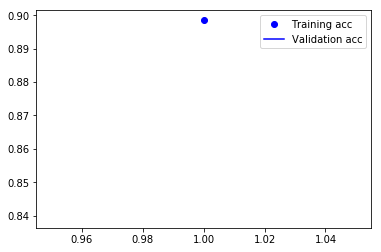

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.legend()
plt.figure()
plt.show()

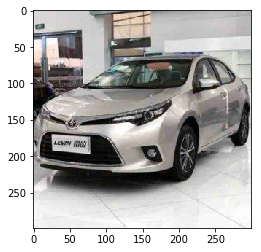

[('雷凌', 1.0), ('卡罗拉', 3.8738754e-08), ('朗逸', 7.533924e-09), ('凯美瑞', 7.023314e-09), ('轩逸', 1.2697866e-09), ('威驰', 7.0497497e-10), ('天籁', 6.546807e-10), ('速腾', 2.1985343e-10), ('福睿斯', 1.5923676e-10), ('帕萨特', 7.792455e-11), ('迈腾', 7.0798895e-11), ('福克斯', 4.8901043e-11), ('蒙迪欧', 4.754954e-11), ('途观', 1.9866185e-11), ('飞度', 1.2508337e-11), ('雅阁', 4.610662e-12), ('锋范', 2.6156965e-12)]


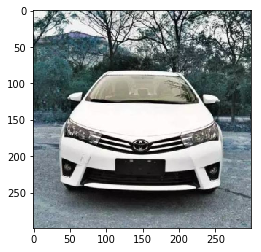

[('卡罗拉', 0.9940807), ('雷凌', 0.0033620095), ('朗逸', 0.0015567391), ('凯美瑞', 0.0005487392), ('轩逸', 0.0003089403), ('速腾', 5.7646e-05), ('威驰', 3.259759e-05), ('帕萨特', 2.560735e-05), ('途观', 9.866893e-06), ('天籁', 7.5959124e-06), ('迈腾', 7.3878828e-06), ('锋范', 1.2858776e-06), ('雅阁', 3.5618834e-07), ('福睿斯', 1.4258087e-07), ('蒙迪欧', 1.3834472e-07), ('飞度', 8.456746e-08), ('福克斯', 4.1891802e-08)]


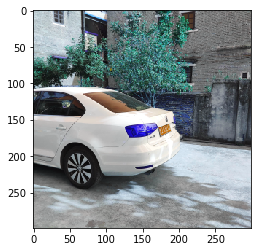

[('速腾', 0.9999989), ('迈腾', 7.650479e-07), ('朗逸', 3.3592468e-07), ('雅阁', 5.8650617e-08), ('帕萨特', 4.7700354e-08), ('锋范', 9.329924e-09), ('福睿斯', 8.491703e-09), ('威驰', 4.982959e-09), ('卡罗拉', 2.0347228e-09), ('凯美瑞', 9.443373e-10), ('天籁', 8.0368506e-10), ('途观', 6.767471e-11), ('轩逸', 5.1892258e-11), ('福克斯', 3.881883e-11), ('蒙迪欧', 2.6273953e-11), ('雷凌', 1.6053778e-11), ('飞度', 5.739128e-12)]


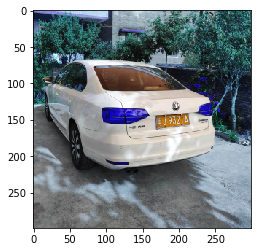

[('速腾', 0.99456066), ('福睿斯', 0.0043566995), ('锋范', 0.00041261283), ('福克斯', 0.0002679044), ('迈腾', 0.00019382099), ('朗逸', 0.00012883378), ('卡罗拉', 4.875534e-05), ('飞度', 1.9583349e-05), ('蒙迪欧', 5.0872686e-06), ('威驰', 3.243938e-06), ('途观', 1.5303184e-06), ('雷凌', 6.109076e-07), ('帕萨特', 3.415331e-07), ('凯美瑞', 1.9785394e-07), ('雅阁', 1.15860196e-07), ('轩逸', 3.7200124e-08), ('天籁', 2.929481e-09)]


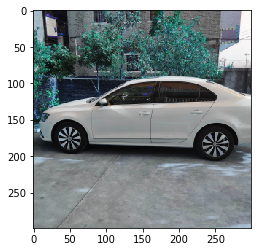

[('速腾', 1.0), ('朗逸', 2.221675e-08), ('帕萨特', 2.1891301e-08), ('天籁', 1.099123e-08), ('迈腾', 6.4471437e-09), ('凯美瑞', 7.9856205e-11), ('威驰', 2.9294647e-11), ('福睿斯', 1.42873395e-11), ('卡罗拉', 8.890572e-12), ('雅阁', 1.8357935e-12), ('雷凌', 1.5573402e-12), ('途观', 1.1768163e-12), ('锋范', 7.4433526e-13), ('福克斯', 2.5053e-13), ('轩逸', 2.1244124e-13), ('蒙迪欧', 1.0316062e-14), ('飞度', 4.9843938e-15)]


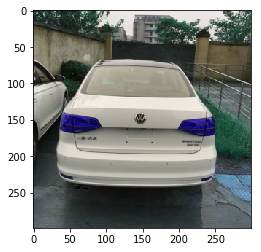

[('速腾', 0.99893254), ('朗逸', 0.0010558197), ('迈腾', 5.894828e-06), ('帕萨特', 3.5883613e-06), ('福克斯', 1.5173716e-06), ('卡罗拉', 2.335266e-07), ('蒙迪欧', 1.3755486e-07), ('途观', 7.6620346e-08), ('锋范', 5.4998736e-08), ('轩逸', 3.125335e-08), ('凯美瑞', 3.0233252e-08), ('福睿斯', 2.6853728e-08), ('威驰', 2.3366015e-08), ('雅阁', 1.7415227e-08), ('天籁', 1.3975816e-08), ('雷凌', 9.1640775e-09), ('飞度', 4.648196e-09)]


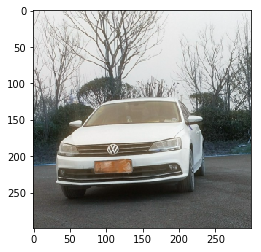

[('速腾', 0.9976368), ('朗逸', 0.0022472348), ('迈腾', 8.862432e-05), ('帕萨特', 1.1521343e-05), ('途观', 1.0109383e-05), ('蒙迪欧', 1.1149486e-06), ('威驰', 9.573658e-07), ('锋范', 8.4226417e-07), ('凯美瑞', 7.0990046e-07), ('福睿斯', 6.511742e-07), ('雅阁', 6.0843894e-07), ('轩逸', 3.4393165e-07), ('雷凌', 2.1476127e-07), ('福克斯', 1.4983034e-07), ('飞度', 1.0178687e-07), ('卡罗拉', 5.6810695e-08), ('天籁', 2.0952012e-08)]


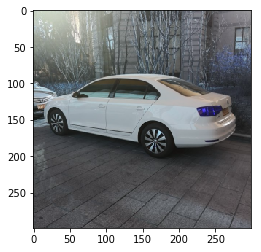

[('速腾', 0.99976844), ('迈腾', 0.0001110601), ('帕萨特', 8.462345e-05), ('朗逸', 1.608939e-05), ('天籁', 1.494308e-05), ('雅阁', 3.8230087e-06), ('福睿斯', 6.8847794e-07), ('卡罗拉', 2.3585812e-07), ('凯美瑞', 1.2336433e-07), ('途观', 4.94727e-08), ('威驰', 3.216279e-08), ('雷凌', 1.0425889e-08), ('蒙迪欧', 8.726355e-09), ('锋范', 8.7244585e-09), ('轩逸', 3.0150749e-09), ('福克斯', 9.212154e-10), ('飞度', 7.6630244e-11)]


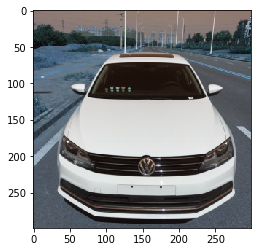

[('速腾', 0.95577514), ('朗逸', 0.032812703), ('迈腾', 0.011203519), ('帕萨特', 6.919482e-05), ('锋范', 4.0221345e-05), ('威驰', 1.767561e-05), ('雅阁', 1.1980692e-05), ('卡罗拉', 1.1165167e-05), ('雷凌', 1.1091725e-05), ('福克斯', 1.0134656e-05), ('轩逸', 9.147851e-06), ('途观', 7.2858234e-06), ('凯美瑞', 7.087542e-06), ('蒙迪欧', 5.5591727e-06), ('福睿斯', 4.318539e-06), ('飞度', 3.2726257e-06), ('天籁', 3.942636e-07)]


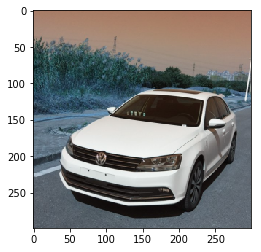

[('速腾', 0.9962417), ('迈腾', 0.0035940383), ('朗逸', 7.891177e-05), ('帕萨特', 2.9947705e-05), ('雅阁', 1.20366885e-05), ('凯美瑞', 9.682955e-06), ('锋范', 7.454914e-06), ('途观', 3.881052e-06), ('蒙迪欧', 3.6292527e-06), ('雷凌', 3.4879486e-06), ('福睿斯', 3.4100046e-06), ('福克斯', 3.1703846e-06), ('威驰', 3.0923536e-06), ('轩逸', 2.7233873e-06), ('卡罗拉', 1.2246024e-06), ('飞度', 8.965502e-07), ('天籁', 6.27302e-07)]


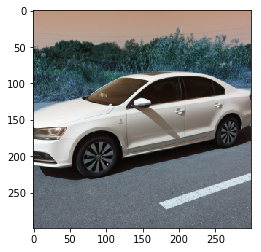

[('速腾', 0.9999982), ('迈腾', 1.4074407e-06), ('锋范', 2.6389776e-07), ('帕萨特', 2.8072396e-08), ('凯美瑞', 1.6235779e-08), ('福睿斯', 1.203741e-08), ('雅阁', 7.912416e-09), ('威驰', 6.886709e-09), ('朗逸', 6.5397345e-09), ('天籁', 5.6343463e-09), ('福克斯', 4.6019446e-09), ('途观', 6.8455064e-10), ('蒙迪欧', 2.4129831e-10), ('飞度', 2.072858e-10), ('雷凌', 1.8712787e-10), ('卡罗拉', 1.4610216e-10), ('轩逸', 1.0548698e-11)]


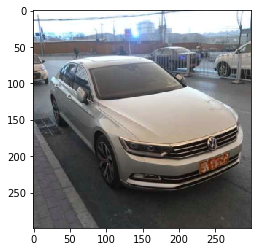

[('迈腾', 0.97684175), ('帕萨特', 0.019761985), ('朗逸', 0.0025665637), ('速腾', 0.0007196578), ('雅阁', 3.697214e-05), ('天籁', 2.6411206e-05), ('途观', 1.8026825e-05), ('凯美瑞', 1.3393728e-05), ('蒙迪欧', 6.655439e-06), ('轩逸', 5.649766e-06), ('雷凌', 8.8888163e-07), ('福睿斯', 8.111866e-07), ('卡罗拉', 4.8584496e-07), ('威驰', 3.931912e-07), ('福克斯', 1.9668458e-07), ('锋范', 7.957894e-08), ('飞度', 4.612814e-08)]


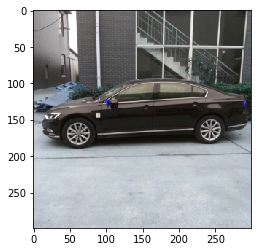

[('迈腾', 0.99820423), ('帕萨特', 0.0017090995), ('天籁', 4.0416297e-05), ('朗逸', 2.622295e-05), ('雅阁', 9.871916e-06), ('蒙迪欧', 3.7184639e-06), ('速腾', 3.0695721e-06), ('凯美瑞', 2.6644195e-06), ('轩逸', 2.897969e-07), ('雷凌', 1.254807e-07), ('途观', 1.02545904e-07), ('福睿斯', 2.1425123e-08), ('卡罗拉', 1.4588165e-08), ('福克斯', 4.8842703e-09), ('威驰', 8.292778e-10), ('飞度', 4.995577e-10), ('锋范', 2.5589916e-10)]


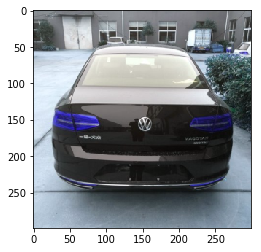

[('朗逸', 0.9351101), ('速腾', 0.046310466), ('迈腾', 0.01856221), ('帕萨特', 1.242534e-05), ('蒙迪欧', 3.849279e-06), ('雷凌', 3.7814516e-07), ('威驰', 2.745026e-07), ('途观', 2.0784628e-07), ('福睿斯', 9.742767e-08), ('卡罗拉', 5.605738e-08), ('凯美瑞', 2.1716673e-08), ('福克斯', 1.3241654e-08), ('雅阁', 7.3437527e-09), ('轩逸', 5.8376437e-09), ('天籁', 4.8670974e-09), ('锋范', 4.017119e-09), ('飞度', 1.5895493e-09)]


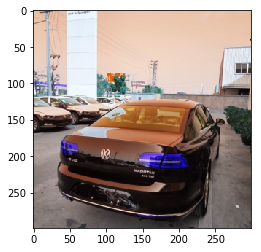

[('迈腾', 0.7734864), ('帕萨特', 0.20753136), ('朗逸', 0.009034575), ('速腾', 0.008119448), ('雷凌', 0.0011865915), ('雅阁', 0.00027423934), ('蒙迪欧', 0.0002433705), ('凯美瑞', 0.000109249995), ('天籁', 5.168876e-06), ('卡罗拉', 3.1265722e-06), ('福睿斯', 1.9882368e-06), ('威驰', 1.7077623e-06), ('途观', 1.5537922e-06), ('福克斯', 8.8692207e-07), ('轩逸', 2.7477404e-07), ('锋范', 8.142779e-08), ('飞度', 2.3683782e-08)]


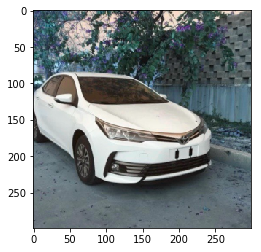

[('卡罗拉', 0.9609274), ('雷凌', 0.025085516), ('速腾', 0.0033720064), ('朗逸', 0.003139646), ('凯美瑞', 0.0019045677), ('帕萨特', 0.0016350836), ('迈腾', 0.0008903085), ('锋范', 0.000747464), ('轩逸', 0.00059791986), ('威驰', 0.0005185502), ('途观', 0.00026921256), ('雅阁', 0.00023714644), ('天籁', 0.00021012174), ('福睿斯', 0.00015060639), ('福克斯', 0.00013132453), ('飞度', 0.00012926487), ('蒙迪欧', 5.39184e-05)]


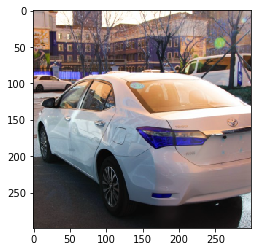

[('卡罗拉', 0.9980965), ('雷凌', 0.0019001503), ('凯美瑞', 1.8221177e-06), ('威驰', 1.0787929e-06), ('锋范', 4.946272e-07), ('速腾', 2.0953513e-08), ('雅阁', 1.4314258e-08), ('朗逸', 1.1759686e-08), ('福克斯', 1.488583e-09), ('福睿斯', 6.911234e-10), ('飞度', 5.1528404e-10), ('蒙迪欧', 4.1434414e-10), ('轩逸', 3.6135192e-10), ('帕萨特', 1.1206401e-10), ('天籁', 3.3287692e-11), ('迈腾', 1.9349881e-11), ('途观', 8.323292e-13)]


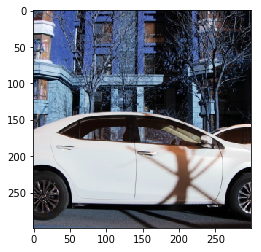

[('卡罗拉', 0.6924938), ('雷凌', 0.25309104), ('凯美瑞', 0.040903885), ('蒙迪欧', 0.0064116395), ('速腾', 0.002969017), ('福睿斯', 0.0014112309), ('迈腾', 0.0008523404), ('雅阁', 0.00077761244), ('锋范', 0.0006165646), ('帕萨特', 0.00026875467), ('朗逸', 6.4532804e-05), ('飞度', 4.0799387e-05), ('福克斯', 3.78838e-05), ('轩逸', 3.1727446e-05), ('威驰', 1.6636119e-05), ('天籁', 1.1995181e-05), ('途观', 5.66874e-07)]


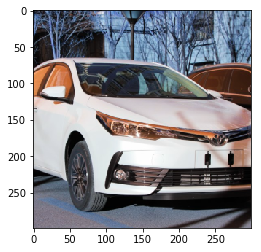

[('卡罗拉', 0.9953022), ('雷凌', 0.0043381853), ('凯美瑞', 0.00034838522), ('朗逸', 2.9194273e-06), ('轩逸', 2.4838275e-06), ('威驰', 1.8256628e-06), ('雅阁', 1.3239753e-06), ('速腾', 8.868987e-07), ('帕萨特', 7.642964e-07), ('天籁', 3.6898564e-07), ('迈腾', 2.9351318e-07), ('途观', 2.1678991e-07), ('锋范', 9.674404e-08), ('蒙迪欧', 8.9789545e-08), ('飞度', 5.588518e-09), ('福睿斯', 4.606416e-09), ('福克斯', 2.3624624e-09)]


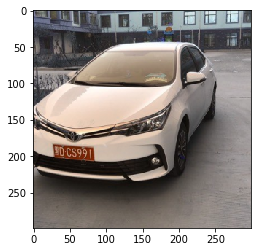

[('雷凌', 0.9378522), ('卡罗拉', 0.06199274), ('威驰', 8.844947e-05), ('速腾', 2.3976052e-05), ('凯美瑞', 1.6710626e-05), ('迈腾', 6.2510976e-06), ('帕萨特', 5.821948e-06), ('朗逸', 5.050913e-06), ('雅阁', 2.7171573e-06), ('天籁', 2.0948382e-06), ('途观', 9.624348e-07), ('轩逸', 8.541659e-07), ('蒙迪欧', 6.4084594e-07), ('锋范', 6.348578e-07), ('福睿斯', 3.48037e-07), ('飞度', 3.3416393e-07), ('福克斯', 1.7284806e-07)]


In [12]:
from keras.preprocessing import image
import numpy as np
import cv2
from mytool import MyTool
test_imgs=['/data/keras/download/qiche/timg2.jpg',
          '/data/keras/download/qiche/timg.jpg',
          '/data/keras/download/qiche/su1.jpg',
          '/data/keras/download/qiche/su2.jpg',
          '/data/keras/download/qiche/su3.jpg',
          '/data/test/su21.jpg',
          '/data/test/su22.jpg',
          '/data/test/su23.jpg',
          '/data/test/su24.jpeg',
          '/data/test/su25.jpeg',
          '/data/test/su26.jpeg',
           '/data/test/mt20.jpg',
           '/data/test/mt21.jpg',
           '/data/test/mt22.jpg',
           '/data/test/mt23.jpg',
           '/data/test/kll20.jpg',
            '/data/test/kll21.jpg',
            '/data/test/kll22.jpg',
            '/data/test/kll23.jpg',
            '/data/test/kll24.jpg',
          ]

for img_path in test_imgs:
    #img = image.load_img(img_path, target_size=(img_height, img_width))
    img =cv2.imread(img_path)
#     plt.imshow(img)
#     plt.show()
    img=MyTool.cro_img(img,img_height,img_width)
    plt.imshow(img)
    plt.show()
    
    x = image.img_to_array(img)
    x=x/255
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    paixu=dict(zip(train_generator.class_indices,preds[0]))
    paixu= sorted(paixu.items(), key=lambda x: x[1], reverse=True)
    print(paixu)